In [1]:
!pip install gensim
import nltk
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Download tokenizer
nltk.download('punkt')
nltk.download('punkt_tab') # Added to fix LookupError

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
sentences = [
    "football match was exciting",
    "team scored a great goal",
    "player won the tournament",
    "new smartphone has better processor",
    "technology is growing fast",
    "software development is important",
    "basketball game was intense",
    "computer science is evolving"
]

# 0 = sports, 1 = tech
labels = [0,0,0,1,1,1,0,1]


tokenized = [nltk.word_tokenize(s.lower()) for s in sentences]
w2v = Word2Vec(
    sentences=tokenized,
    vector_size=50,
    window=3,
    min_count=1,
    workers=1
)

In [3]:
max_len = max(len(s) for s in tokenized)

def sentence_to_vector(sentence):
    vecs = [w2v.wv[word] for word in sentence]

    # padding
    while len(vecs) < max_len:
        vecs.append(np.zeros(50))

    return np.array(vecs)

X = np.array([sentence_to_vector(s) for s in tokenized])
y = np.array(labels)

# Proper tensor conversion (no warning)
X = torch.from_numpy(X).float()
# print(X)
y = torch.from_numpy(y).long()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Conv1d expects (channels, seq_len)
        return self.X[idx].transpose(0,1), self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=2, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=2)


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=50, out_channels=32, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=2) # Corrected in_channels
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

        # Corrected final size calculation:
        # max_len = 5 (from dataset)
        # After conv1 (kernel=2): length = 5 - 2 + 1 = 4
        # After conv2 (kernel=2): length = 4 - 2 + 1 = 3
        # After pool(2): length = floor((3 - 2)/2 + 1) = 1
        self.fc1 = nn.Linear(32 * 1, 16) # Corrected from 32 * 2 to 32 * 1
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 20

training_losses = [] # To store loss for visualization

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    training_losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 2.1301
Epoch 2, Loss: 2.0767
Epoch 3, Loss: 2.0719
Epoch 4, Loss: 2.0617
Epoch 5, Loss: 2.0612
Epoch 6, Loss: 2.0301
Epoch 7, Loss: 1.9634
Epoch 8, Loss: 1.8866
Epoch 9, Loss: 1.6972
Epoch 10, Loss: 1.4394
Epoch 11, Loss: 1.0544
Epoch 12, Loss: 0.6256
Epoch 13, Loss: 0.3396
Epoch 14, Loss: 0.1318
Epoch 15, Loss: 0.0491
Epoch 16, Loss: 0.0109
Epoch 17, Loss: 0.0024
Epoch 18, Loss: 0.0006
Epoch 19, Loss: 0.0002
Epoch 20, Loss: 0.0001


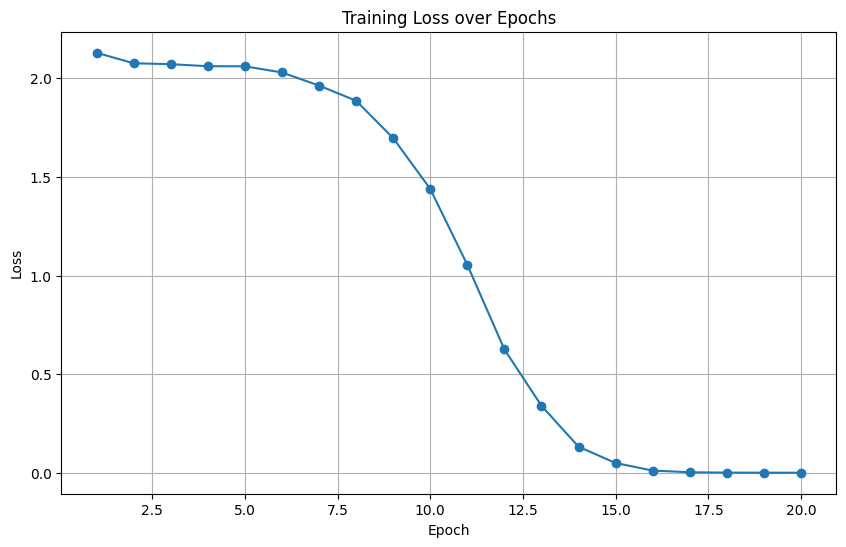

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu()

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))


Test Accuracy: 1.0
